# ch04/gradient_1d.py

In [ ]:
import numpy as np
import matplotlib.pylab as plt


def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)


def function_1(x):
    return 0.01*x**2 + 0.1*x 


def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    #y = f(x) - d*x
    #return lambda t: d*t + y
    return lambda t: d*t
     
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")

tf = tangent_line(function_1, 5)
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2)
plt.show()


# ch04/gradient_2d.py

In [ ]:
# cf.http://d.hatena.ne.jp/white_wheels/20100327/p3
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D


def _numerical_gradient_no_batch(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        # f(x+h)
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)
        
        # f(x-h)
        x[idx] = tmp_val - h 
        fxh2 = f(x)  # f(x-h)

        # grad(xi)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val  # 値を元に戻す # 恢复到初始的值
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad


def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1) # 实际可以是 y = x1^2+x2^2+x3^2....


if __name__ == '__main__':
    x0 = np.arange(-2, 2.5, 0.25)
    x1 = np.arange(-2, 2.5, 0.25)
    X, Y = np.meshgrid(x0, x1)
    
    X = X.flatten()
    Y = Y.flatten()

    grad = numerical_gradient(function_2, np.array([X, Y]).T).T

    plt.figure()
    plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid()
    plt.draw()
    plt.show()

# ch04/gradient_method.py
- 如下代码的作用是展示如何求函数的最小值 - 
- 比如 f = (x1+1)^2 + (x2-1)^2 ,可以看到函数最终会到接近0的位置，并且找到x1和x2，其实对于其他函数来说也是可以的。
- 但有些函数在这个区域是单调的，
- 比如椭圆1=x^2/a+y^2/b - 1，以及 y = x^2

In [ ]:
import numpy as np
import matplotlib.pylab as plt


def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)


def function_2(x):
    # return x[0]**2 + x[1]**2
    return x[0]**2/2 + x[1]**2/4 - 1 # f = x1^2/a + x2^2/b - 1

init_x = np.array([-3.0, 4.0])

lr = 0.1
step_num = 50
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()
print(x_history)
for h in x_history:
    print(function_2(h))

# ch04/gradient_simplenet.py

In [ ]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient


class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3)

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

x = np.array([0.6, 0.9])
t = np.array([0, 0, 1])

net = simpleNet()

f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W)

print(dW)

# ch04/two_layer_net.py

In [1]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from common.functions import *
from common.gradient import numerical_gradient
import numpy as np


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

# ch04/train_neuralnet.py

train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.8205666666666667, 0.8222
train acc, test acc | 0.8838833333333334, 0.8874
train acc, test acc | 0.8985166666666666, 0.9031
train acc, test acc | 0.9078833333333334, 0.9102
train acc, test acc | 0.9111, 0.9154
train acc, test acc | 0.91645, 0.9178
train acc, test acc | 0.9205833333333333, 0.9245
train acc, test acc | 0.9250333333333334, 0.9268
train acc, test acc | 0.9276, 0.9292
train acc, test acc | 0.9305333333333333, 0.9323
train acc, test acc | 0.9335833333333333, 0.9349
train acc, test acc | 0.93635, 0.937
train acc, test acc | 0.9390166666666667, 0.9376
train acc, test acc | 0.94065, 0.9403
train acc, test acc | 0.9436666666666667, 0.9417
train acc, test acc | 0.9454, 0.9436


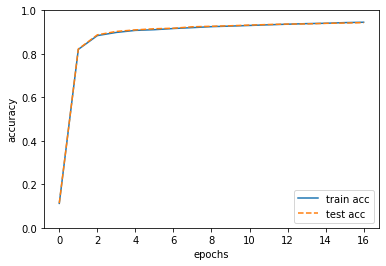

In [2]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)

iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 随机取数据 - 但是有些数据可能不会被用到
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    # 顺序取数据
    # k = i % train_size/batch_size
    # x_batch = x_train[k*batch_size:(k+1)*batch_size]
    # t_batch = t_train[k*batch_size:(k+1)*batch_size]
    
    # 勾配の計算
    # grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()